In [1]:
import sys
!{sys.executable} -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
import re
import numpy as np
import pandas as pd

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [3]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 
                   'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 
                   'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 
                   'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 
                   'need', 'even', 'right', 'line', 'even', 'also', 'may', 
                   'take', 'come', 'http','https','www','com','@','...','…', 'var', 
                   'ref', 'document', 'referrer', 'var', 'bbpath', 'href', 'archive', 
                   'function', 'beige','book', 'federal', 'reserve', 'summary', 
                   'indexof', 'backtoresults','history', 'go', 'else', 'window', 
                   'location', 'back', 'search','this', 'report', 'prepared', 'federal', 
                   'reserve', 'bank', 'summarizes','january', 'february', 'march', 'april', 
                   'may', 'june', 'july', 'august','september', 'october', 'november', 
                   'december', 'atlanta', 'boston', 'chicago','cleveland', 'dallas', 
                   'kansas', 'minneapolis', 'york', 'philadelphia', 'richmond', 'san', 
                   'francisco', 'st', 'louis', 'officials', 'comments', 
                   'views', 'commentary', 'national', 'based', 'information', 'collected',
                   'received', 'contacts', 'outside', 'system', 'page', 'url', 'link', 'district'])

In [5]:
%matplotlib inline

warnings.filterwarnings("ignore",category=DeprecationWarning)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Importing The Beige Book (National Summary) Dataset

In [6]:
df = pd.read_csv('./data/beige_book_national.csv')
df.head()

,Unnamed: 0,national_report,date
0,0,\n\r\n var ref = document.referrer;\r\n ...,2019-04
1,1,\n\r\n var ref = document.referrer;\r\n ...,2019-03
2,2,\n\r\n var ref = document.referrer;\r\n ...,2019-01
3,3,\n\r\n var ref = document.referrer;\r\n ...,2018-12
4,4,\n\r\n var ref = document.referrer;\r\n ...,2018-10


In [7]:
df.'drop(columns='Unnamed: 0', inplace=True)'

In [8]:
df.head()

,national_report,date
0,\n\r\n var ref = document.referrer;\r\n ...,2019-04
1,\n\r\n var ref = document.referrer;\r\n ...,2019-03
2,\n\r\n var ref = document.referrer;\r\n ...,2019-01
3,\n\r\n var ref = document.referrer;\r\n ...,2018-12
4,\n\r\n var ref = document.referrer;\r\n ...,2018-10


## Tokenize Sentences and Clean

In [9]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df['national_report'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['var', 'ref', 'document', 'referrer', 'var', 'bbpath', 'beige', 'book', 'archive', 'function', 'backtoresults', 'if', 'ref', 'indexof', 'bbpath', 'history', 'go', 'else', 'window', 'location', 'href', 'back', 'to', 'archive', 'search', 'beige', 'book', 'national', 'summary', 'april', 'this', 'report', 'was', 'prepared', 'at', 'the', 'federal', 'reserve', 'bank', 'of', 'st', 'louis', 'based', 'on', 'information', 'collected', 'on', 'or', 'before', 'april', 'this', 'document', 'summarizes', 'comments', 'received', 'from', 'contacts', 'outside', 'the', 'federal', 'reserve', 'system', 'and', 'is', 'not', 'commentary', 'on', 'the', 'views', 'of', 'federal', 'reserve', 'officials', 'overall', 'economic', 'activity', 'economic', 'activity', 'expanded', 'at', 'slight', 'to', 'moderate', 'pace', 'in', 'march', 'and', 'early', 'april', 'while', 'most', 'districts', 'reported', 'that', 'growth', 'continued', 'at', 'similar', 'pace', 'as', 'the', 'previous', 'report', 'few', 'districts', 'report

## Build the Bigram, Trigram Models and Lemmatize

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [ ]:
# !python3 -m spacy download en  # run in terminal once

In [12]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Build a Topic Model

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=20190511,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha='auto',
                                           iterations=100,
                                           per_word_topics=True)

In [19]:
pprint(lda_model.print_topics())

[(0,
  '0.003*"delia" + 0.002*"intermediary" + 0.001*"coexist" + 0.001*"classical" '
  '+ 0.001*"sometime" + 0.001*"convergence" + 0.001*"tomorrow" + 0.001*"nadir" '
  '+ 0.001*"frederic" + 0.001*"issuing"'),
 (1,
  '0.026*"increase" + 0.026*"activity" + 0.021*"price" + 0.020*"city" + '
  '0.020*"note" + 0.018*"sale" + 0.018*"new" + 0.016*"demand" + 0.012*"remain" '
  '+ 0.011*"strong"'),
 (2,
  '0.028*"strike" + 0.015*"inflation" + 0.013*"policy" + 0.011*"director" + '
  '0.011*"businessman" + 0.008*"administration" + 0.008*"academic" + '
  '0.008*"general_motor" + 0.006*"opinion" + 0.006*"feel"'),
 (3,
  '0.017*"sale" + 0.012*"new" + 0.012*"price" + 0.011*"loan" + 0.011*"demand" '
  '+ 0.011*"increase" + 0.011*"continue" + 0.010*"construction" + '
  '0.010*"strong" + 0.009*"rate"')]


## What is the Dominant topic and its percentage contribution in each document?

In [20]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [21]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9723,"increase, activity, price, city, note, sale, n...","[overall, economic, activity, economic, activi..."
1,1,1.0,0.9819,"increase, activity, price, city, note, sale, n...","[city, overall, economic, activity, economic, ..."
2,2,1.0,0.9725,"increase, activity, price, city, note, sale, n...","[overall, economic, activity, economic, activi..."
3,3,1.0,0.9730,"increase, activity, price, city, note, sale, n...","[overall, economic, activity, economy, expand,..."
4,4,1.0,0.9908,"increase, activity, price, city, note, sale, n...","[overall, economic, activity, economic, activi..."


In [22]:
df_dominant_topic.tail()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
424,424,3.0,0.9892,"sale, new, price, loan, demand, increase, cont...","[redbook, optimistic, early, month, consensus,..."
425,425,3.0,0.9311,"sale, new, price, loan, demand, increase, cont...","[consensus, economy, sidewise, movement, sign,..."
426,426,3.0,0.8829,"sale, new, price, loan, demand, increase, cont...","[current, comment, businessman, banker, contin..."
427,427,3.0,0.8094,"sale, new, price, loan, demand, increase, cont...","[economic, condition, indicate, banker, busine..."
428,428,3.0,0.8295,"sale, new, price, loan, demand, increase, cont...","[initial, economic, condition, gather, directo..."


In [23]:
set(df_dominant_topic['Dominant_Topic'])

{1.0, 2.0, 3.0}

In [24]:
df_dominant_topic['Keywords'][0]

'increase, activity, price, city, note, sale, new, demand, remain, strong'

In [25]:
df_dominant_topic['Keywords'][428]

'sale, new, price, loan, demand, increase, continue, construction, strong, rate'

## The most representative sentence for each topic

In [26]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1.0,0.9948,"increase, activity, price, city, note, sale, new, demand, remain, strong","[business, indicate, economic, activity, continue, expand, region, sector, early, mid, note, loc..."
1,2.0,0.8922,"strike, inflation, policy, director, businessman, administration, academic, general_motor, opini...","[file, find, object, request, find, server, follow, inaccurate, notify, discover, broken, site, ..."
2,3.0,0.9980,"sale, new, price, loan, demand, increase, continue, construction, strong, rate","[area, remain, strong, economic, weakness, appear, spread, coal, strike, begin, consensus, deter..."


In [27]:
sent_topics_sorteddf_mallet['Keywords'][0]

'increase, activity, price, city, note, sale, new, demand, remain, strong'

In [28]:
sent_topics_sorteddf_mallet['Keywords'][2]

'sale, new, price, loan, demand, increase, continue, construction, strong, rate'

In [29]:
sent_topics_sorteddf_mallet['Keywords'][1]

'strike, inflation, policy, director, businessman, administration, academic, general_motor, opinion, feel'

## Frequency Distribution of Word Counts in Documents

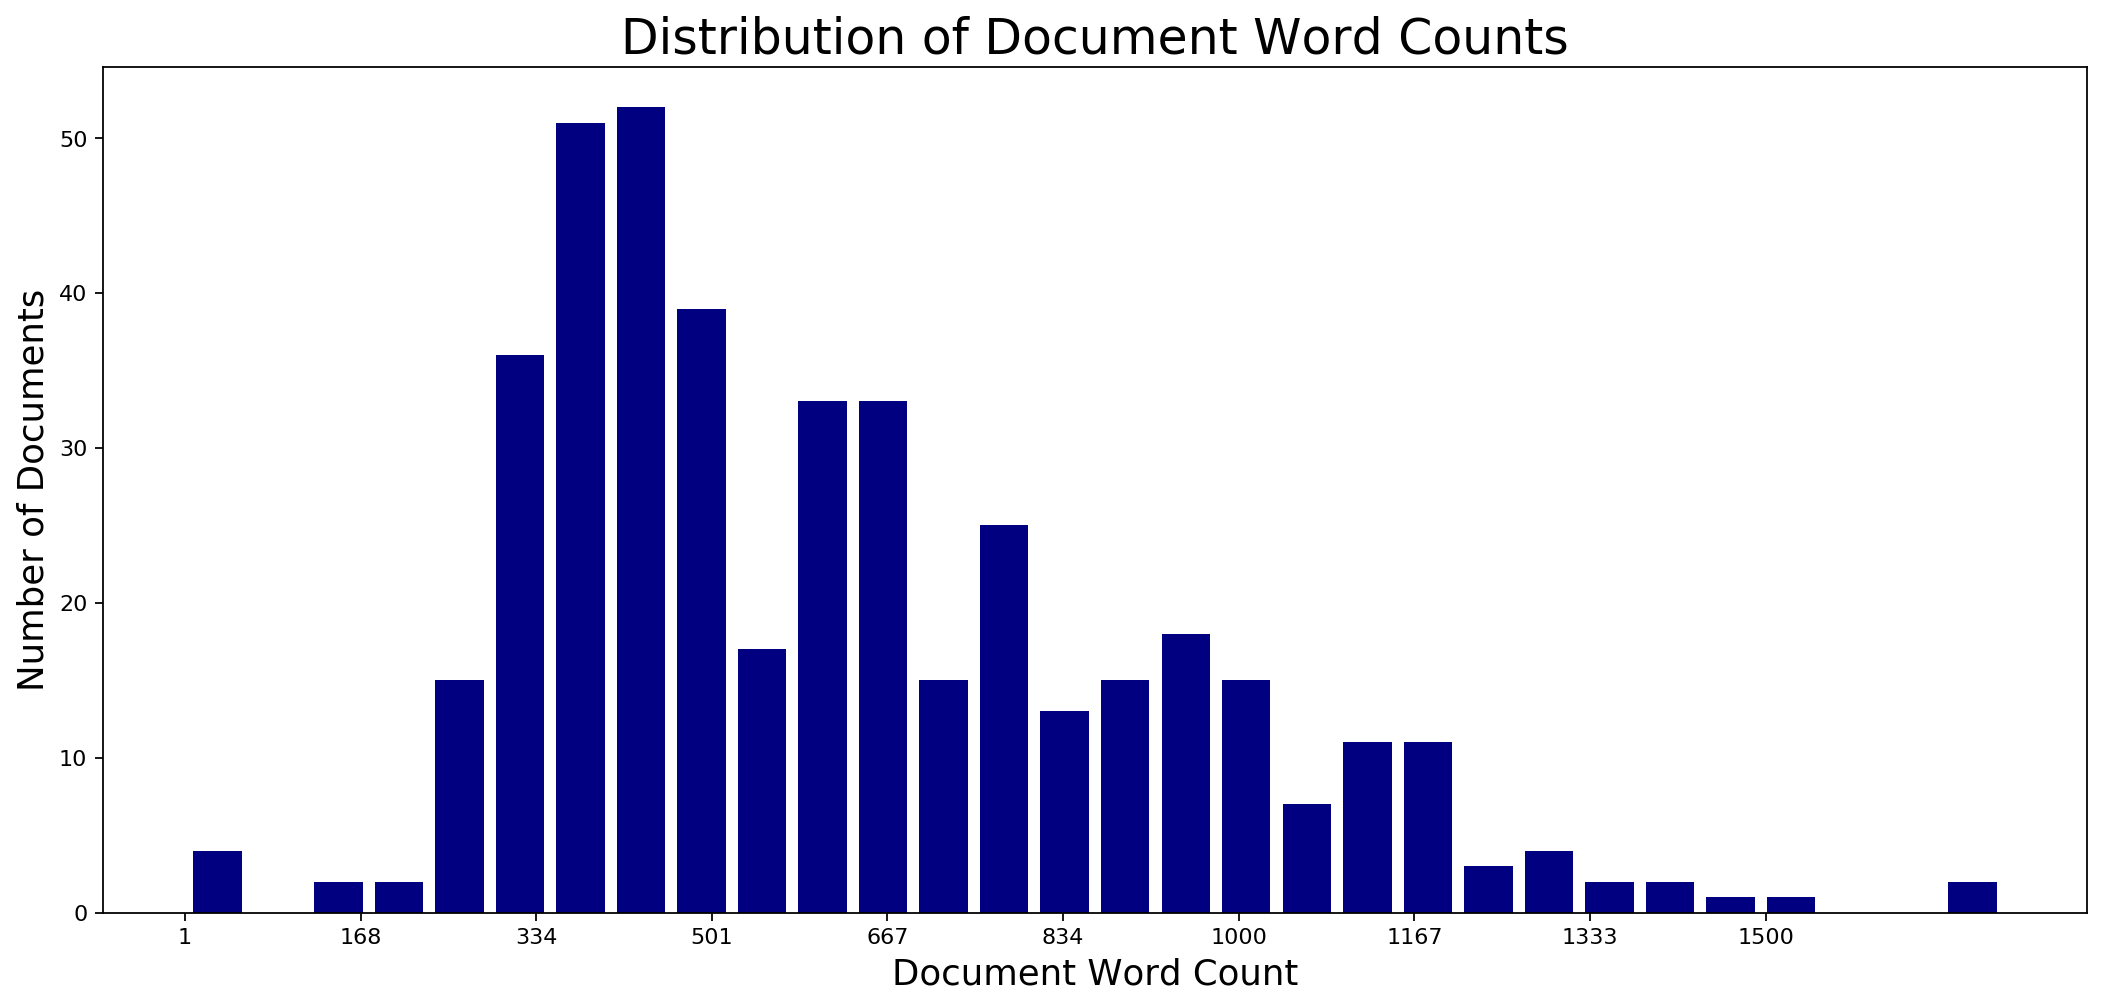

In [30]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins=30, color='navy', rwidth=0.8)
# plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
# plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
# plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
# plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
# plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

#plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.ylabel('Number of Documents', fontsize=16)
plt.xlabel('Document Word Count', fontsize=16)
#plt.tick_params(size=10)
plt.xticks(np.linspace(1,1500,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig('./Images/Distribution_count.png')
plt.show();

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


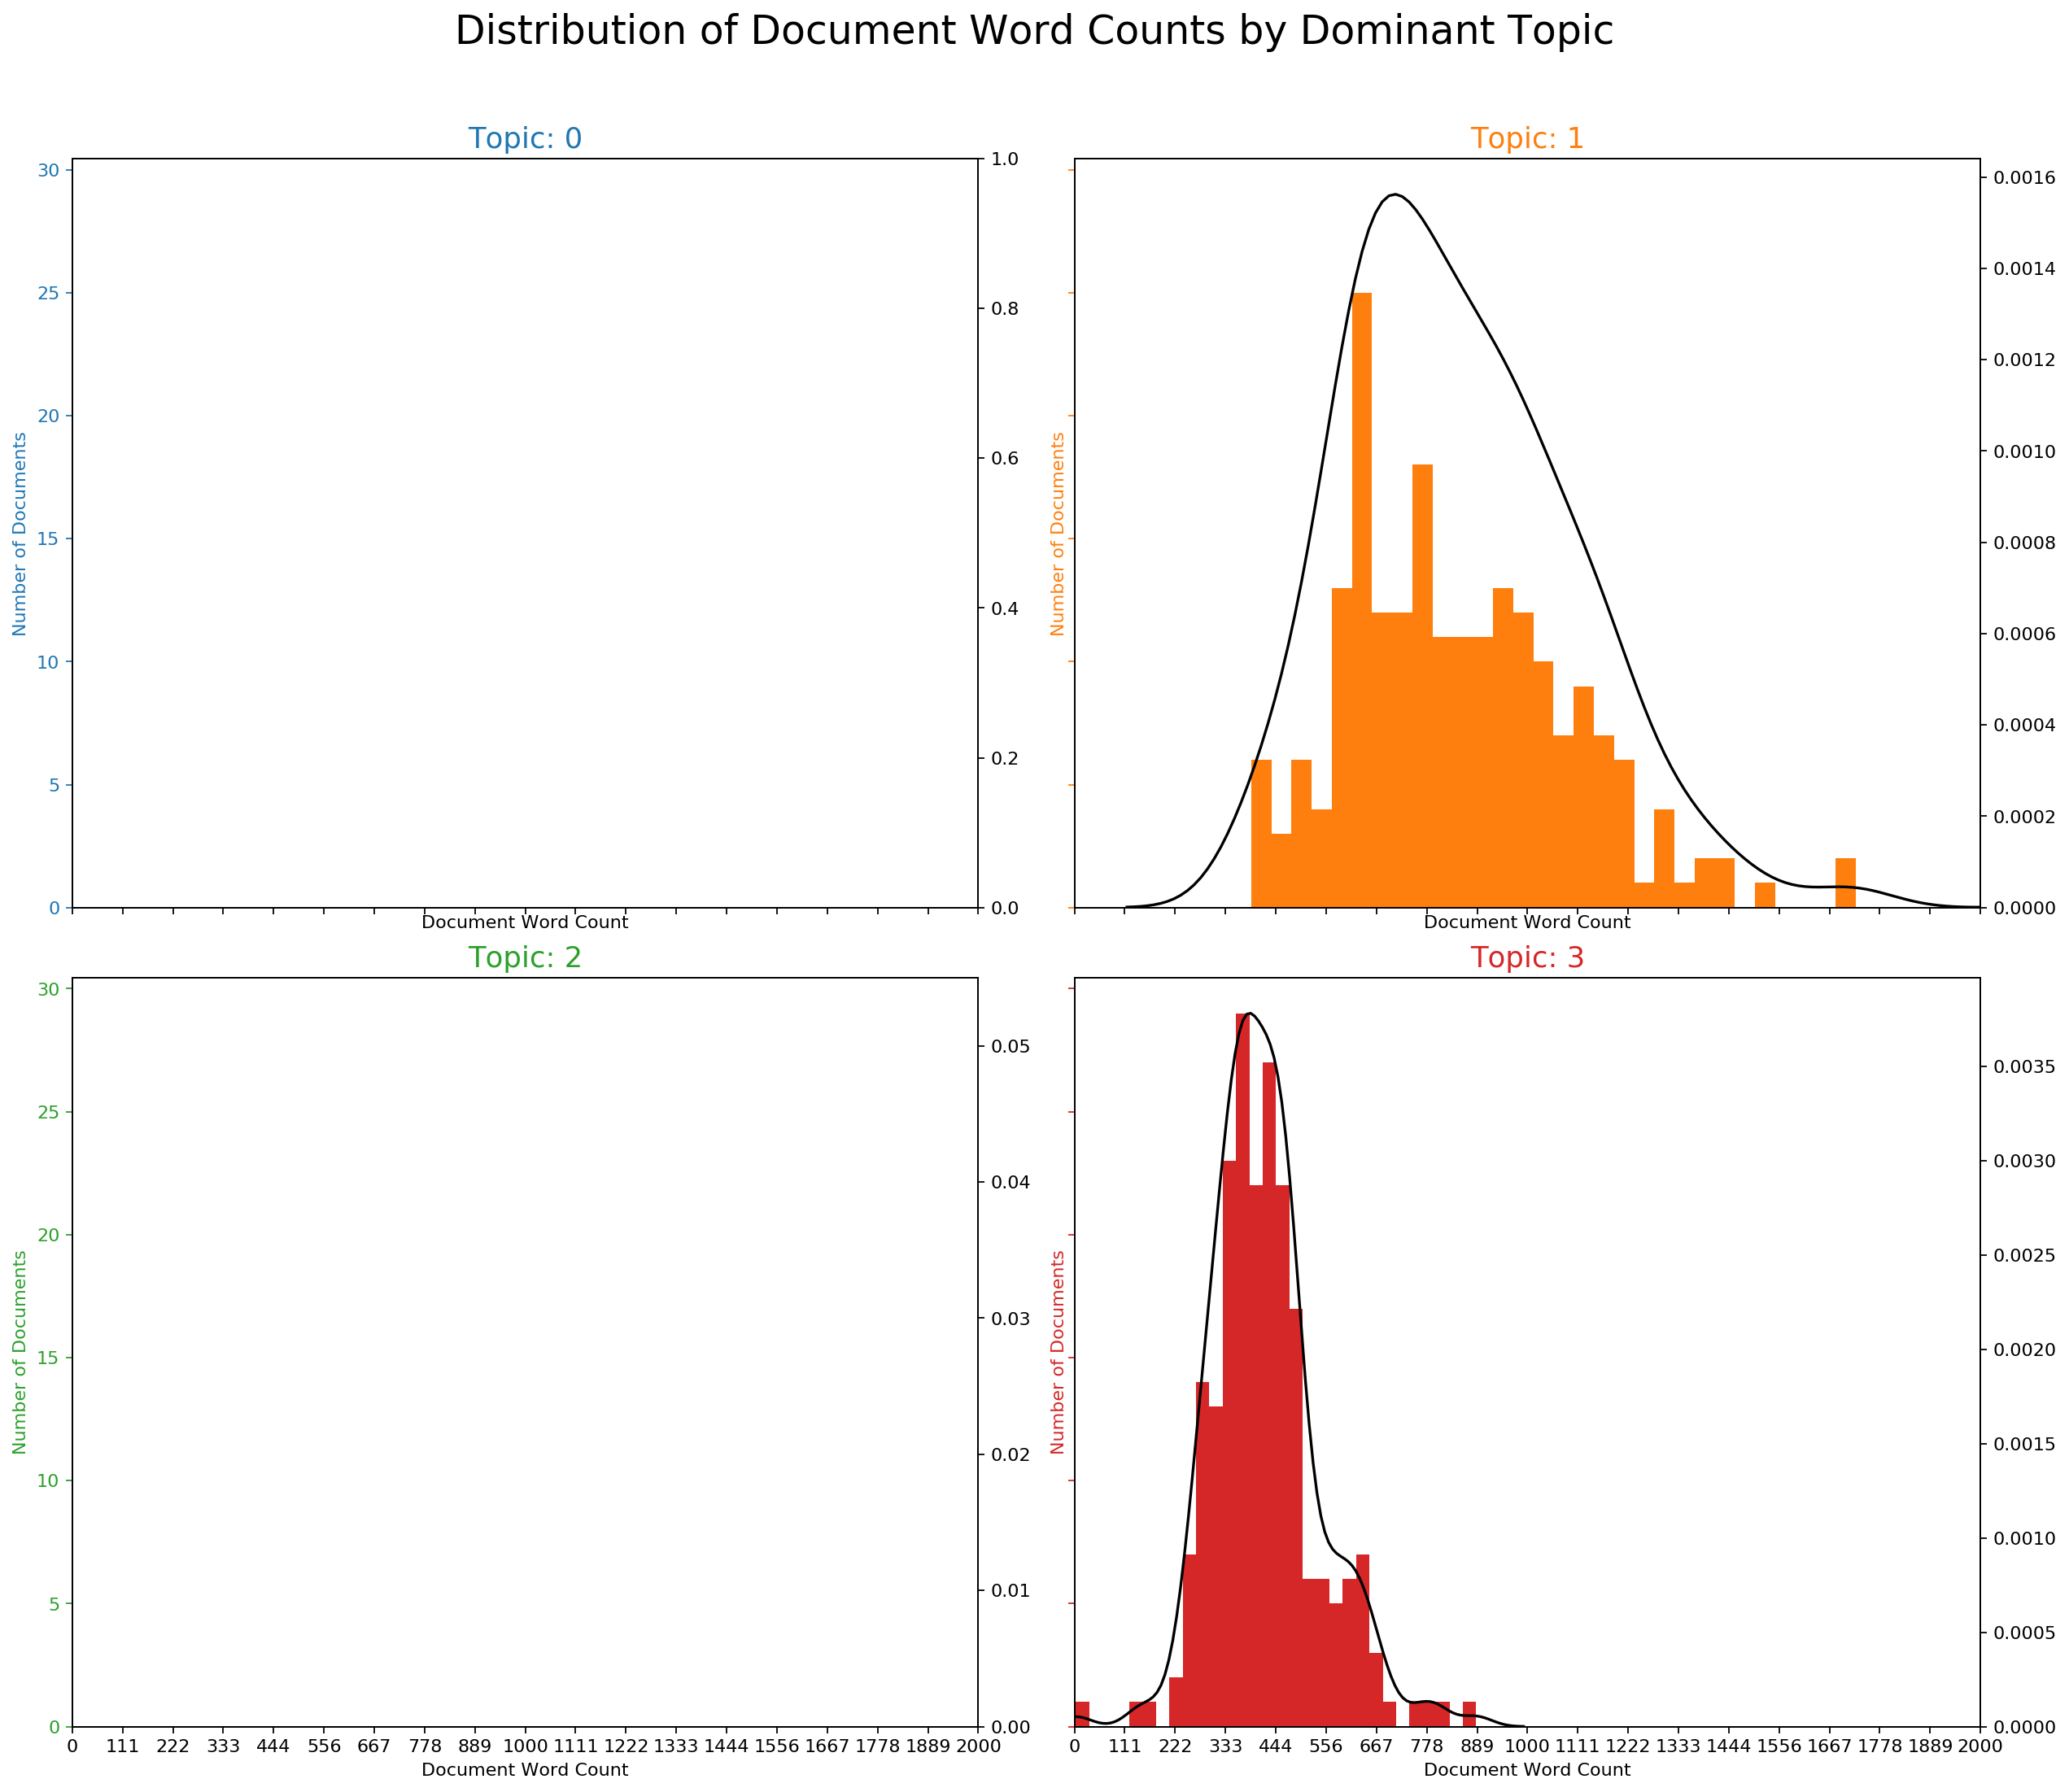

In [31]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2, figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 30, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 2000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,2000,19))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## Word Clouds of Top N Keywords in Each Topic

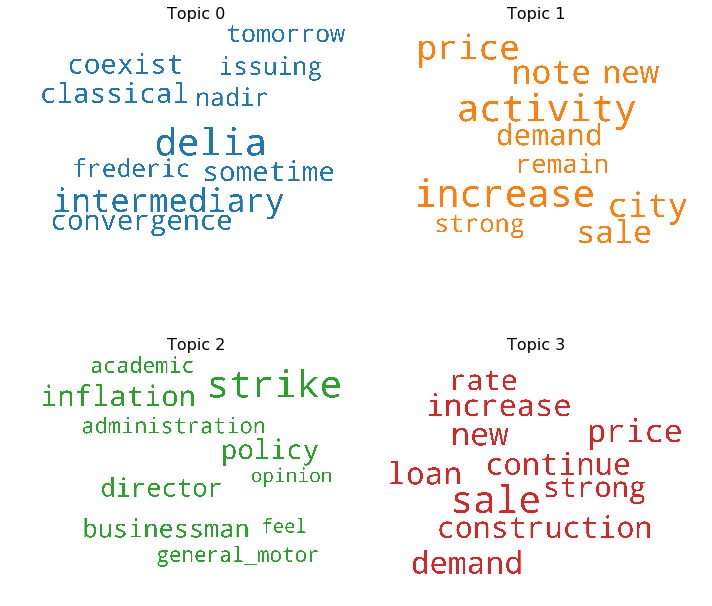

In [32]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

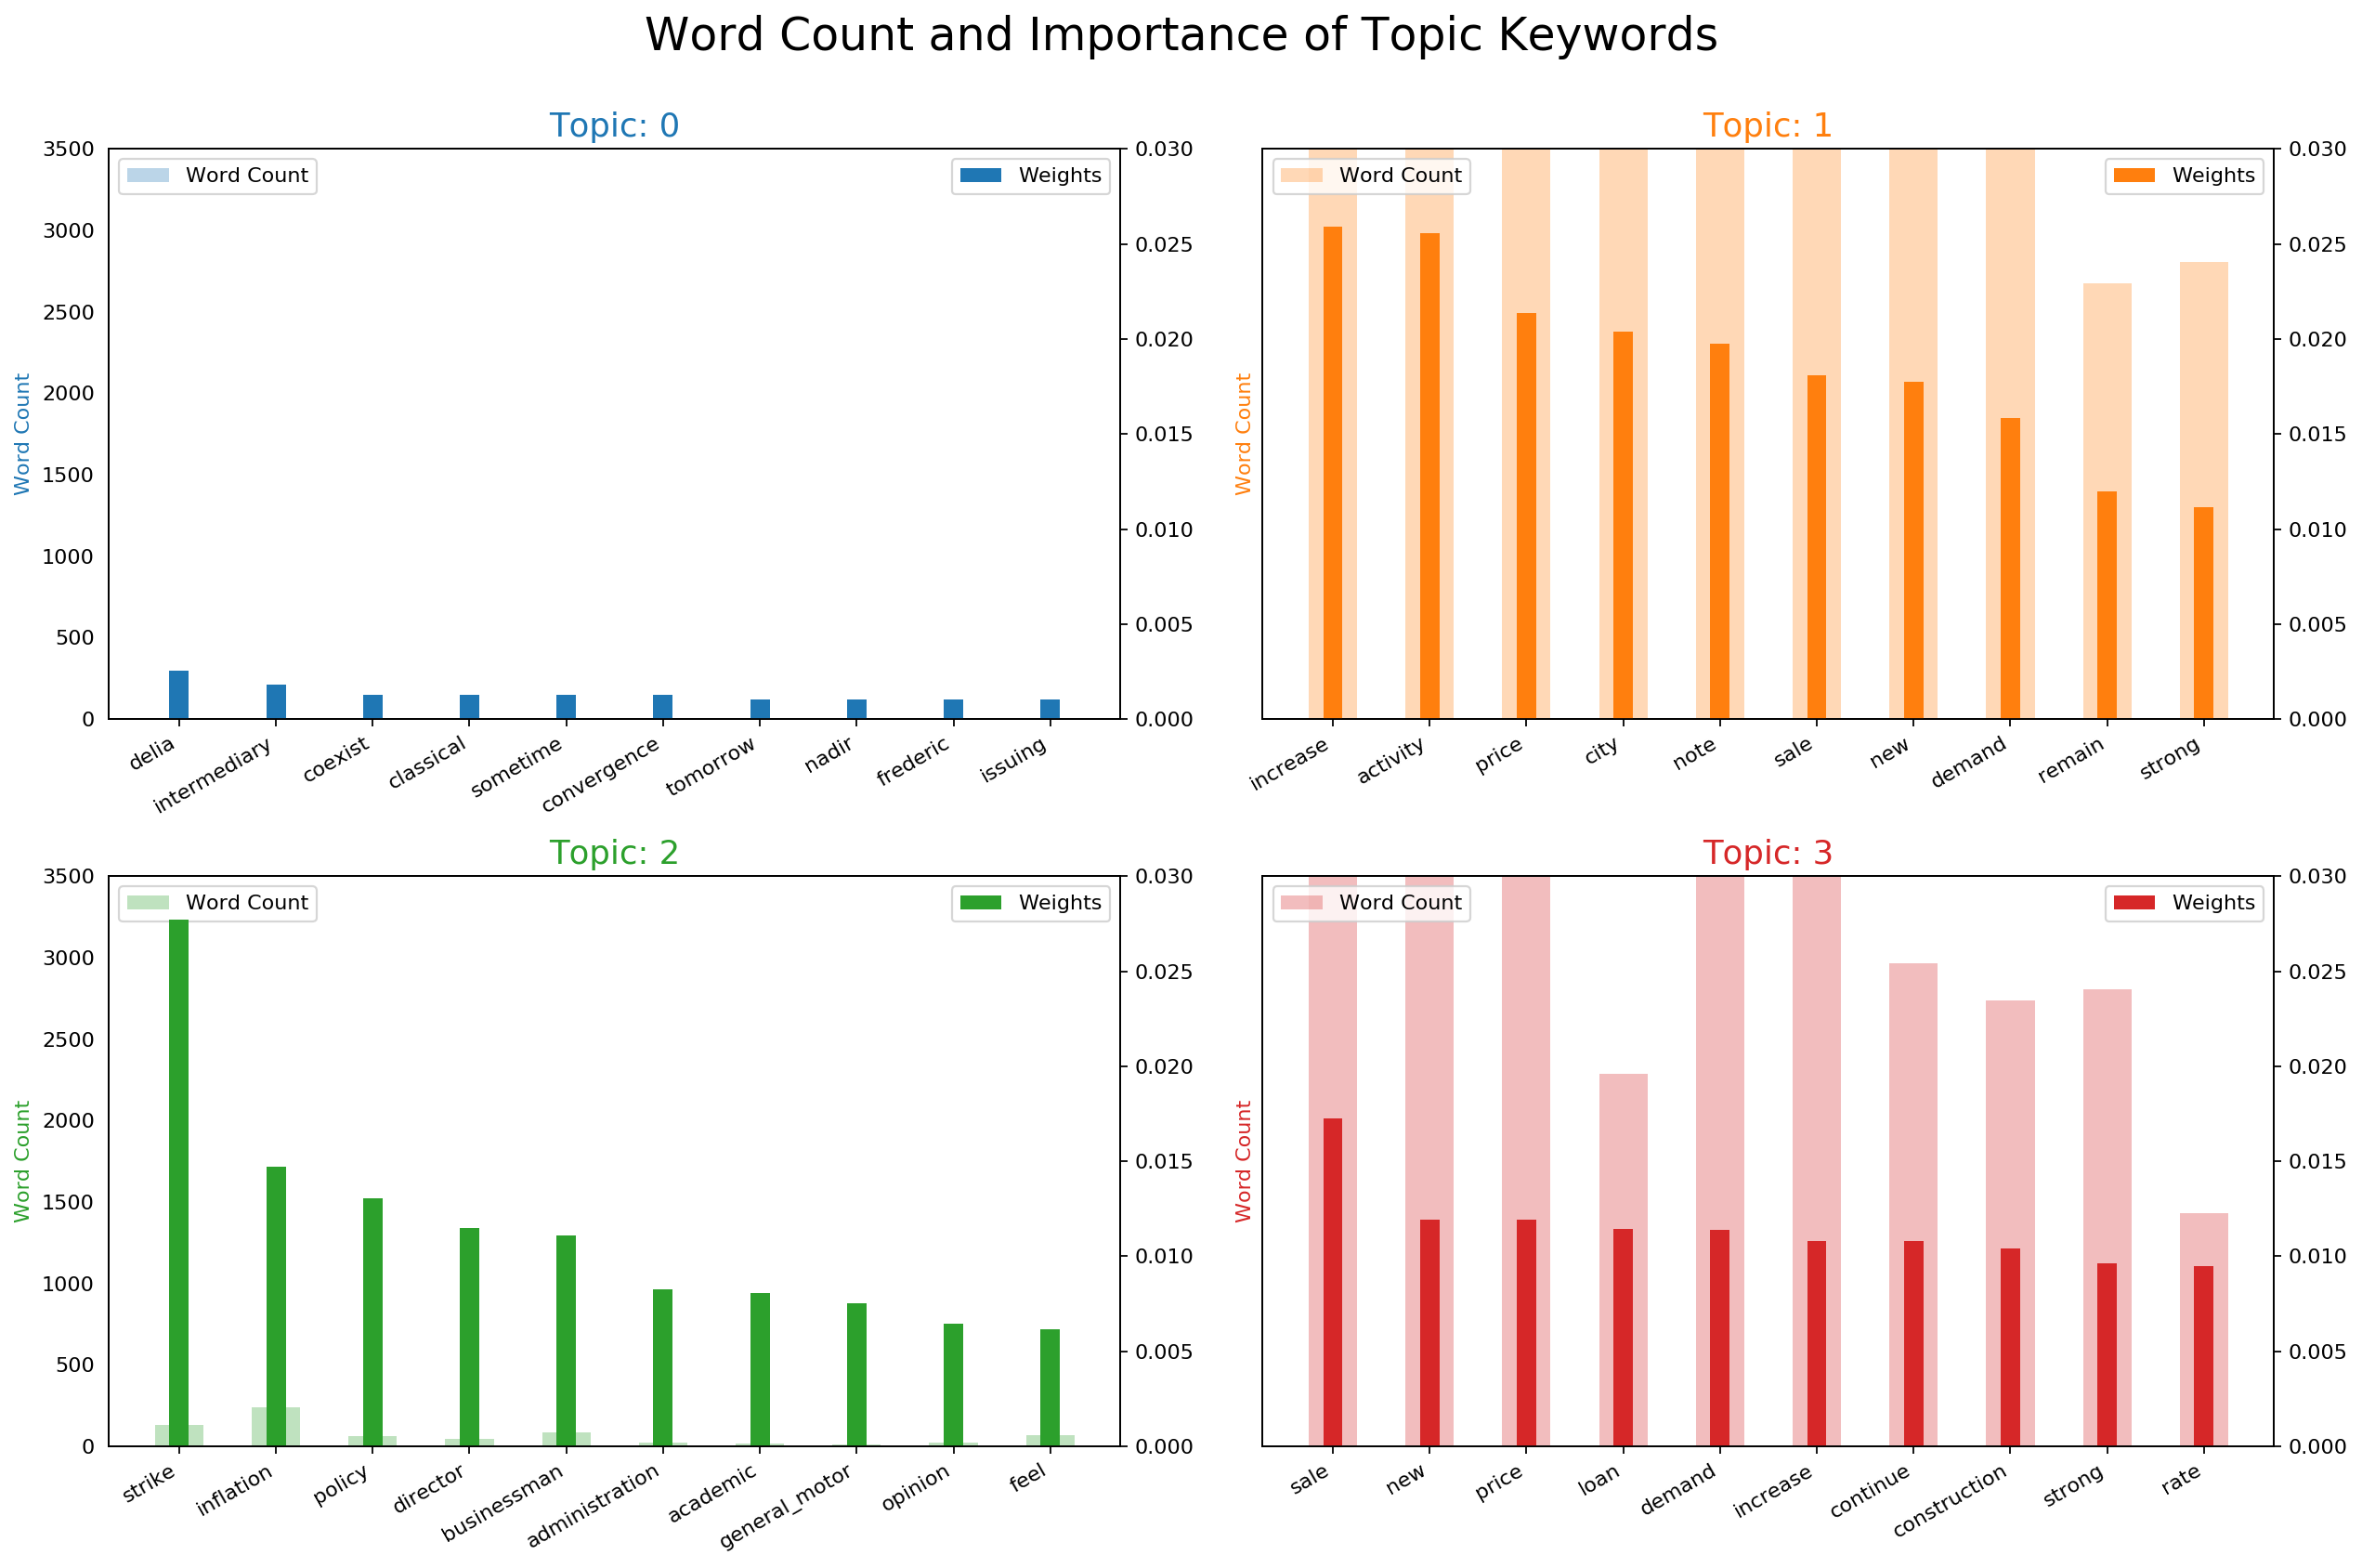

In [33]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence Chart Colored by Topic

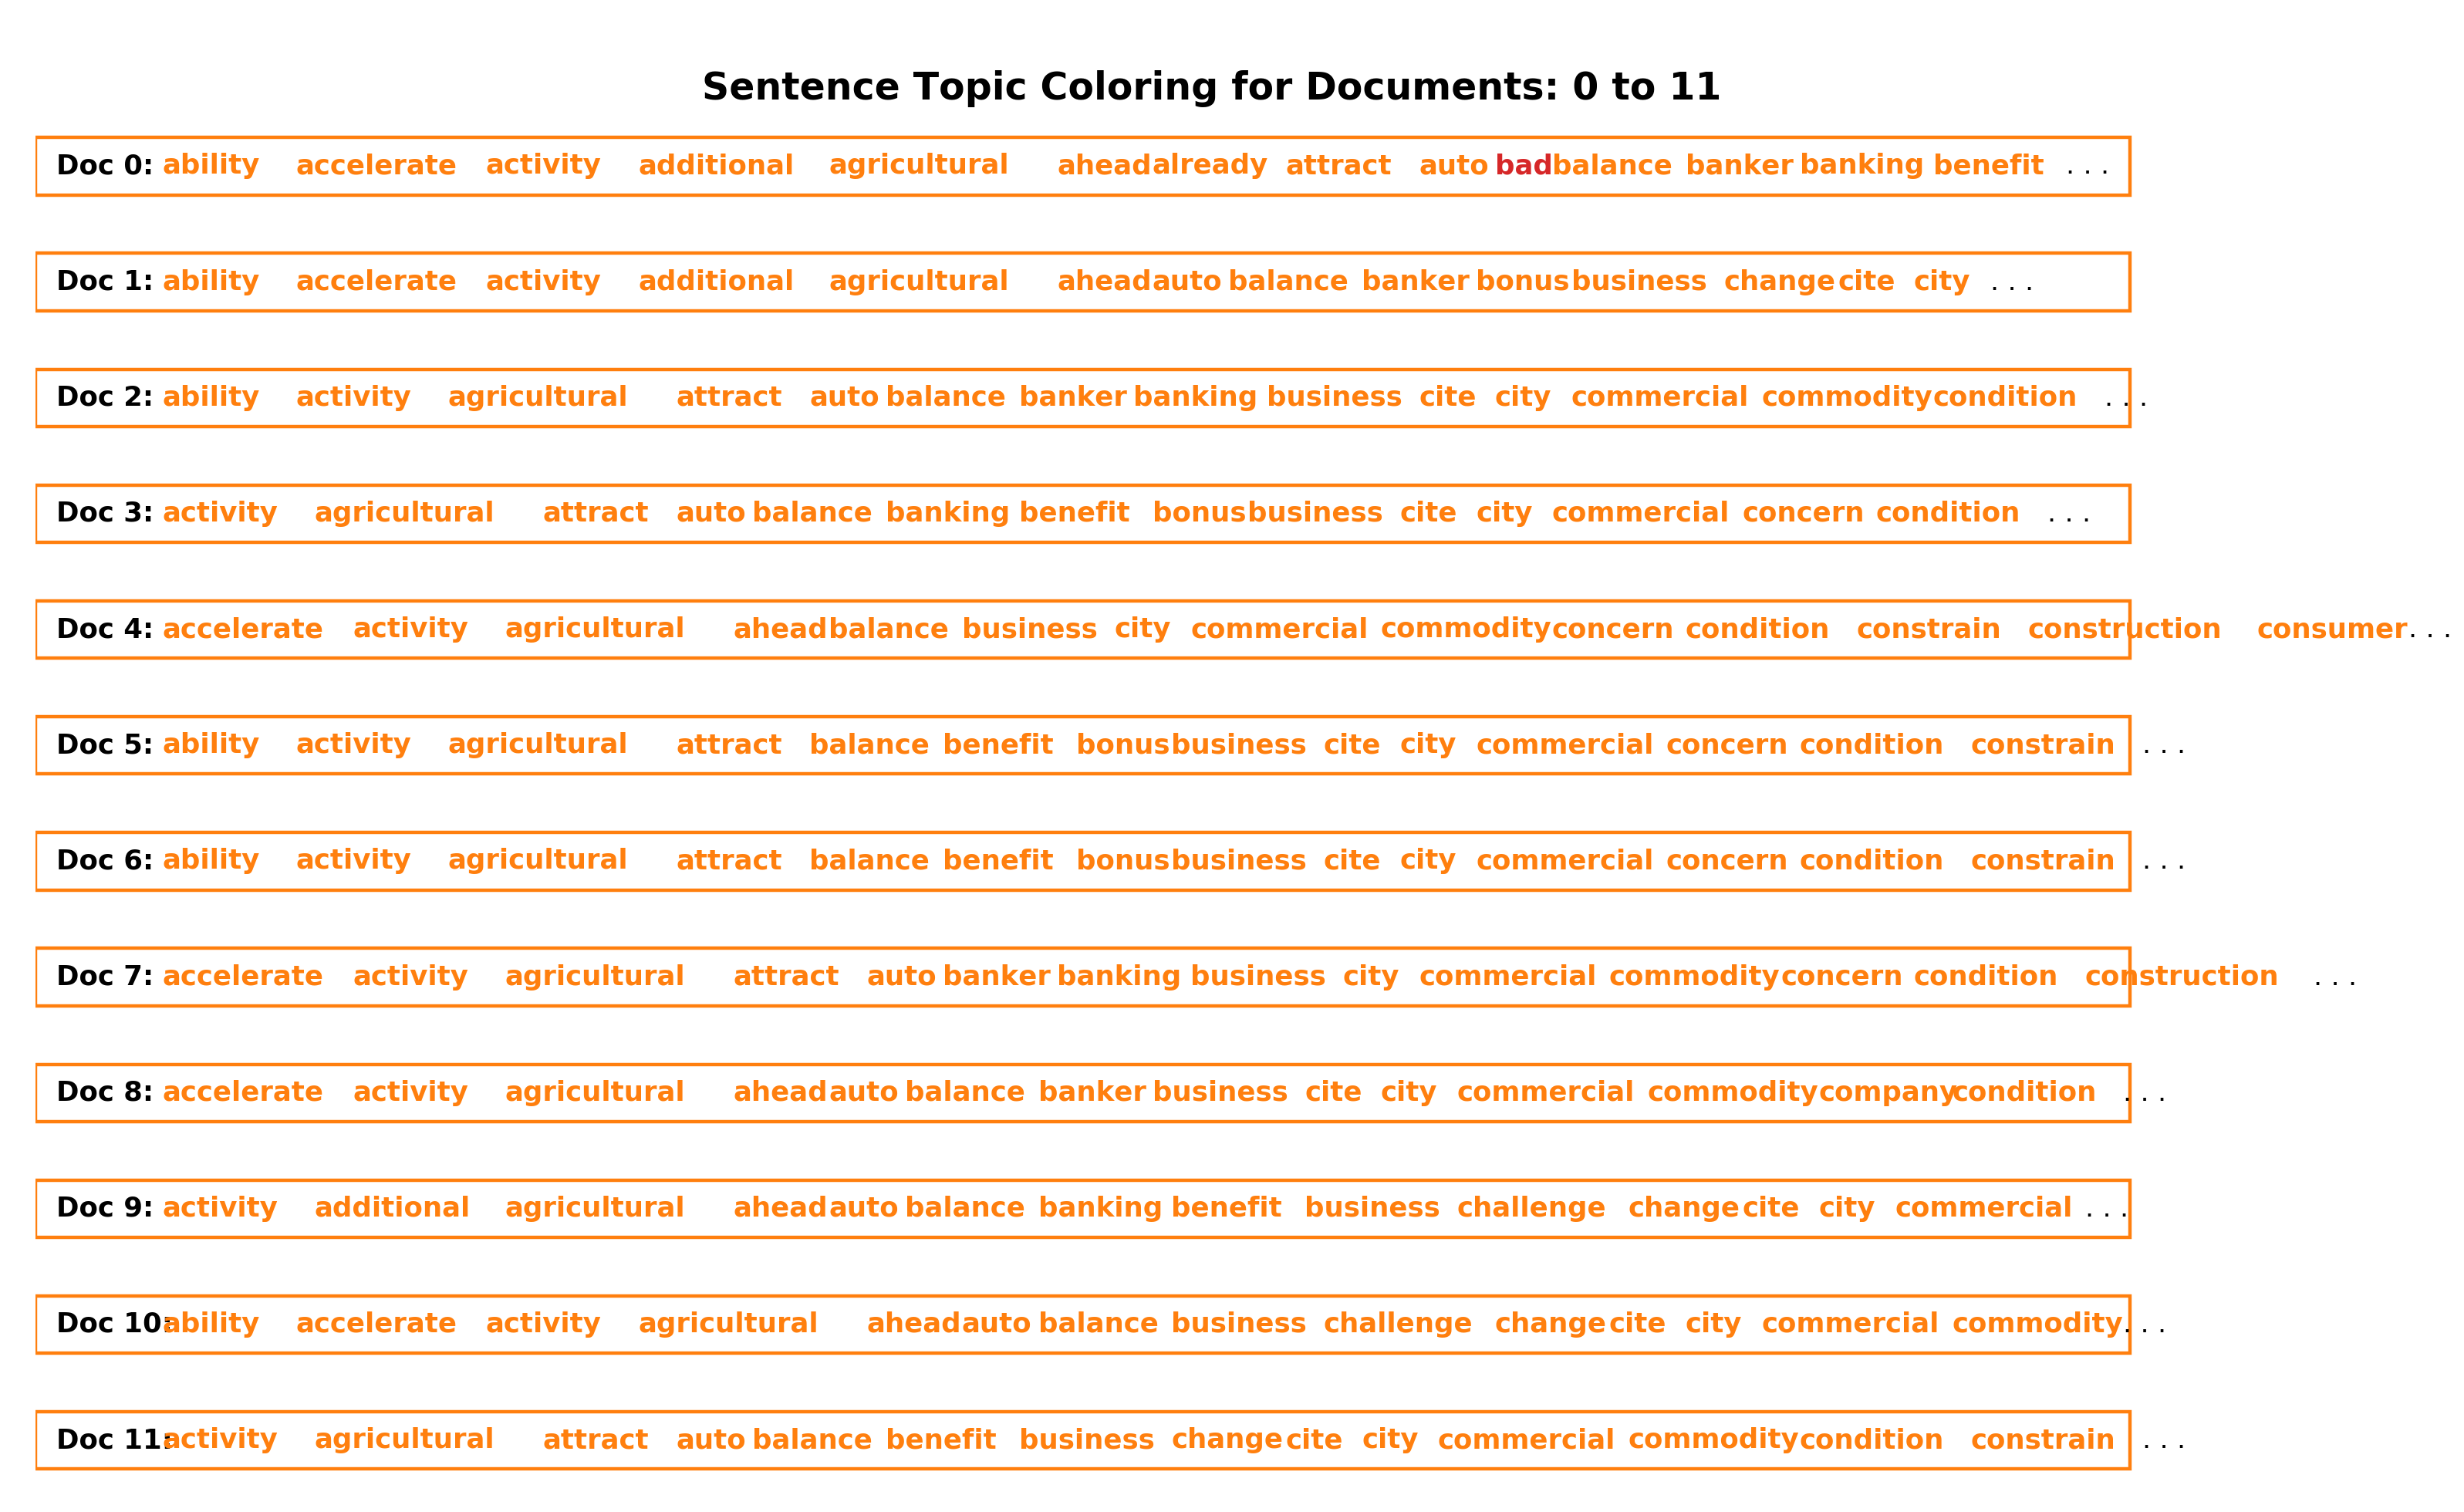

In [34]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## What are the most discussed topics in the documents?

In [35]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

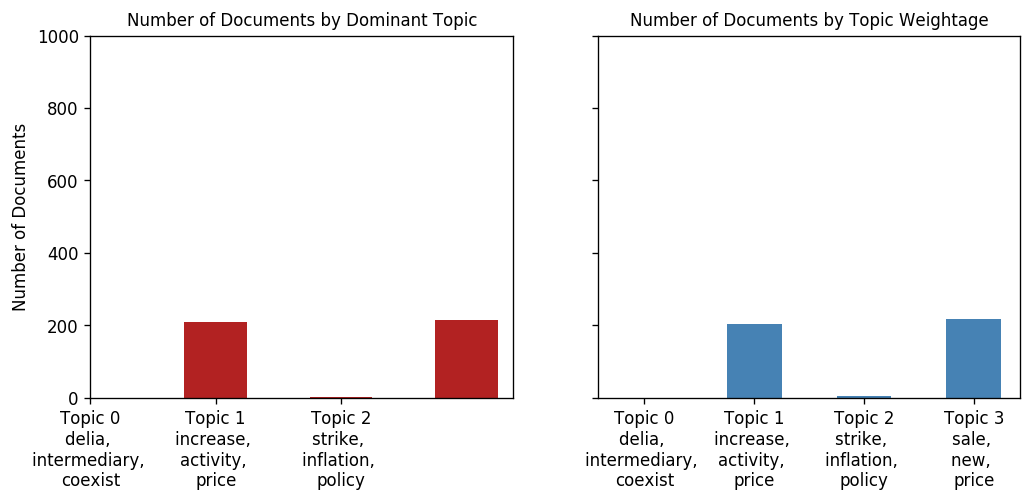

In [36]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# https://www.washingtonpost.com/archive/local/1984/03/23/otto-eckstein-economist-adviser-to-presidents-dies/d3d7b76c-759b-45f4-b578-ac832dd11f39/?noredirect=on&utm_term=.fc8c1f5d59b6

## t-SNE Clustering Chart

In [37]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [38]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

In [39]:
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [40]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=20190511, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 429 samples in 0.000s...
[t-SNE] Computed neighbors for 429 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 429 / 429
[t-SNE] Mean sigma: 0.036001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.873234
[t-SNE] KL divergence after 1000 iterations: 0.130449


Loading BokehJS ...

## pyLDAVis

In [ ]:
#!pip install pyLDAvis

In [41]:
import pyLDAvis.gensim

In [42]:
pyLDAvis.enable_notebook()

In [43]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.251420 -0.066117       1        1  59.938961
3      0.193823  0.055197       2        1  39.493557
2     -0.282892 -0.063862       3        1   0.558739
0     -0.162351  0.074782       4        1   0.008743, topic_info=     Category         Freq            Term        Total  loglift  logprob
95    Default   276.000000       inflation   276.000000  30.0000  30.0000
372   Default   282.000000            find   282.000000  29.0000  29.0000
1541  Default   170.000000          strike   170.000000  28.0000  28.0000
191   Default  1297.000000         service  1297.000000  27.0000  27.0000
4435  Default   177.000000     businessman   177.000000  26.0000  26.0000
51    Default  1414.000000          estate  1414.000000  25.0000  25.0000
2     Default  4728.000000        activity  4728.000000  24.0000  24.0000
356   Default   722.000000         capital   722.000000  23.0000  23.0000
170   Default  1417.000000            rate  1417.000000  22.0000  22.0000
210   Default   858.000000          steady   858.000000  21.0000  21.0000
98    Default  1335.000000       inventory  1335.000000  20.0000  20.0000
171   Default  1450.000000            real  1450.000000  19.0000  19.0000
248   Default   593.000000          appear   593.000000  18.0000  18.0000
232   Default  1415.000000            wage  1415.000000  17.0000  17.0000
220   Default   680.000000         tourism   680.000000  16.0000  16.0000
78    Default  1982.000000          growth  1982.000000  15.0000  15.0000
207   Default   565.000000          stable   565.000000  14.0000  14.0000
55    Default  1284.000000          expect  1284.000000  13.0000  13.0000
126   Default   807.000000          modest   807.000000  12.0000  12.0000
199   Default   805.000000        slightly   805.000000  11.0000  11.0000
250   Default  1106.000000            area  1106.000000  10.0000  10.0000
308   Default    81.000000          policy    81.000000   9.0000   9.0000
1500  Default    88.000000            feel    88.000000   8.0000   8.0000
4233  Default    81.000000        director    81.000000   7.0000   7.0000
96    Default   495.000000           input   495.000000   6.0000   6.0000
242   Default   820.000000          worker   820.000000   5.0000   5.0000
118   Default  1952.000000          market  1952.000000   4.0000   4.0000
128   Default   649.000000           month   649.000000   3.0000   3.0000
146   Default   735.000000           order   735.000000   2.0000   2.0000
111   Default  2216.000000            loan  2216.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
4691   Topic4     0.024231           nadir     0.930040   5.6970  -6.8774
4685   Topic4     0.024231    experimental     0.930040   5.6970  -6.8774
4686   Topic4     0.024231        frederic     0.930040   5.6970  -6.8774
4687   Topic4     0.024231    groundbreake     0.930040   5.6970  -6.8774
4688   Topic4     0.024231           hence     0.930040   5.6970  -6.8774
4683   Topic4     0.024231         anxious     0.930040   5.6970  -6.8774
4692   Topic4     0.024231       prototype     0.930040   5.6970  -6.8774
4693   Topic4     0.024231         rampant     0.930040   5.6970  -6.8774
4695   Topic4     0.024231        tomorrow     0.930040   5.6970  -6.8774
4696   Topic4     0.024231             uaw     0.930040   5.6970  -6.8774
4690   Topic4     0.024231         issuing     0.930040   5.6970  -6.8774
4689   Topic4     0.043032    intermediary     2.826868   5.1597  -6.3031
3730   Topic4     0.007628   complementary     1.132850   4.3440  -8.0332
3728   Topic4     0.007628   accommodative     1.132850   4.3440  -8.0332
3731   Topic4     0.007628         compute     1.132850   4.3440  -8.0332
3734   Topic4     0.007628          gamble     1.132850   4.3440  -8.0332
3736   Topic4     0.007628        irrigate     1.132850   4.3440  -8.0332
3738   